In [2]:
import cupy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy
import h5py
from PIL import Image
import numpy as np
import time
import scipy

from skimage.morphology import binary_dilation
from scipy.optimize import minimize

from scipy import ndimage
from scipy import interpolate

from skimage.morphology import skeletonize, opening, closing, erosion, dilation, disk
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.morphology import convex_hull_image
from skimage.restoration import inpaint
from skimage import feature

from scipy.ndimage import gaussian_filter

/ibira/lnls/labs/tepui/apps/modules/python/3.9.2/lib/python3.9/site-packages/cupy/_environment.py:436: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda110, cupy-cuda112

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


## GPU info

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jun 28 11:30:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      On   | 00000000:90:00.0 Off |                    0 |
| N/A   29C    P0    55W / 400W |     24MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# HIO

In [4]:
def proj_M_gpu( x, data ):

    #'''
    fft  = cupy.fft.fftn(x)
    fabs = cupy.abs(fft)
    whereIszero = (fabs == 0)
    result = data * fft / fabs
    result[whereIszero] = data[whereIszero]
    result[data < 0] = fft[data < 0]
    result = cupy.fft.ifftn( result )
        
    return result
    #'''

    '''
    fft    = cupy.fft.fftn( x )
    phi    = cupy.angle( fft )
    result = data * cupy.exp(1j * phi)
    diff =  cupy.abs(fft) - data
    adiff = cupy.abs(diff)

    result[(data<0) | (adiff < 1)] =  fft[(data<0) | (adiff<1) ]

    tol = 1e-5 #jump@

    result[(data>=0) & (adiff >=1)] = fft[(data>=0) & (adiff>=1) ] * ( data[(data>=0) & (adiff>=1)] / ( numpy.maximum( numpy.abs(fft)[(data>=0) & (adiff>=1)] - diff[(data>=0) & (adiff>=1)]/ adiff[(data>=0) & (adiff>=1)], tol) ) )

    result = cupy.fft.ifftn( result )

    return result
    '''

    '''
    fft    = cupy.fft.fftn( x )
    phi    = cupy.angle(  fft  )
    result = data * cupy.exp(1j * phi)

    #result[(data<0)] =  fft[(data<0)]

    #result[(data>=0)] = fft[(data>=0) ] * ( data[(data>=0)] / ( numpy.maximum( numpy.abs(fft)[(data>=0)] - diff[(data>=0) & (adiff>=1)]/ adiff[(data>=0) & (adiff>=1)], tol) ) )

    result = cupy.fft.ifftn( result )

    #result = cupy.fft.ifftn(result)
    #result
    #result[ data < 0] = -1

    return result
    '''


def ref_M( x, data ):
    proj = proj_M_gpu( x, data)
    result = 2 * proj - cupy.identity(x.shape[0])
    return result

def ref_S(x, supp ):
    proj = proj_S( x, supp )
    result = 2 * proj - cupy.identity(x.shape[0])
    return result


def projection_M_gpu( x, data ):
    return proj_M_gpu(x, data)

def projection_S ( x, supp ):
    y = x * supp
#     y[y.real < 0] = 0.0
#     y[y.imag > 0] = 0

    real = x.real
#     real[x.real < 0] = 0.0 
    
    imag = x.imag
#     imag[imag > 0] = 0
    
    y = real + 1j*imag
    return y * supp

def projection_N ( x, supp ):
    #y = numpy.copy(x)
    #y.imag = 0
    #return y

    y    = numpy.copy(x.real)
    mask = (y < 0)
    y[ mask ] = 0
    return y * supp



def HIO( initial, measure, support, niterations, beta, dev, threshold):

    shrinkWrapSubIter = niterations[1]
    gniteration       = niterations[0]

    mempool = cupy.get_default_memory_pool()
    pinned_mempool = cupy.get_default_pinned_memory_pool()

    cupy.cuda.Device(dev).use()

    with cupy.cuda.Device(dev):

        dsupport = cupy.array(support)
        smeasure = cupy.array( measure )
        x        = cupy.array( initial )
        csupport = cupy.array( 1-support )
        xerror   = cupy.array( initial )

        idx = 0
        sigma = 6
        initialbeta = beta

        while ( idx < gniteration ):
            
            if (idx % 2000 == 0):
                xerror = np.copy(x)

            y = projection_M_gpu( x, smeasure )
            x = projection_S( y, dsupport ) + projection_S( x - beta * y,  1-dsupport )

            if idx % shrinkWrapSubIter == 0 and idx > 0:
                z = cupy.array( gaussian_filter( cupy.abs(x).get(), sigma) )
                dsupport = z > ( threshold/100. ) * z.max()
                sigma = 0.99 * sigma

                beta = initialbeta + (1 - initialbeta)*(1 - numpy.exp(-(idx/7)**3))
                
                if (idx > 10000):
                    x[np.abs(x) < 0.01] = 0+1j*0
                
                if (idx > 2000):
                    real = x.real
                    real[x.real < 0] = 0.0 

                    imag = x.imag
                    imag[imag > 0] = 0.0

                    x = real + 1j*imag
            
            if (idx % 2000 == 0 ):
                res = x.get()
                
                plt.figure(figsize = (5,5))
                plt.imshow(np.abs(res[1*res.shape[0]//3:2*res.shape[0]//3, res.shape[1]//3:2*res.shape[1]//3]))
                plt.colorbar()
                plt.show()
                
                plt.figure(figsize = (5,5))
                plt.imshow(dsupport.get())
                plt.colorbar()
                plt.show()
                
                print(idx, np.linalg.norm(xerror -x))
                
                
            idx += 1

    output = x.get()

    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()

    return output



# wavefront = propagate_beam(wavefront, object_pixel_size, wavelength,+distance) # propagate
def propagate_beam(wavefront, dx, wavelength,distance,propagator='fourier'):
    """ Propagate a wavefront using fresnel ou fourier propagator

    Args:
        wavefront : the wavefront to propagate
        dx : pixel spacing of the wavefront input
        wavelength : wavelength of the illumination
        distance : distance to propagate
        propagator (str, optional): 'fresenel' or 'fourier'. Defaults to 'fresnel'.

    Returns:
        output: propagated wavefront
    """    
    from numpy.fft import fft2, fftshift, ifftshift, ifft2

    ysize, xsize = wavefront.shape
    
    x_array = np.linspace(-xsize/2,xsize/2-1,xsize)
    y_array = np.linspace(-ysize/2,ysize/2-1,ysize)
    
    fx = x_array/(xsize)
    fy = y_array/(ysize)
    
    FX,FY = np.meshgrid(fx,fy)

    if propagator == 'fourier':
        if distance > 0:
            output = fftshift(fft2(fftshift(wavefront)))
        else:
            output = ifftshift(ifft2(ifftshift(wavefront)))            
    elif propagator == 'fresnel':
        # % Calculate approx phase distribution for each plane wave component
        w = FX**2 + FY**2 
        # Compute FFT
        F = fftshift(fft2(fftshift(wavefront)))
        # % multiply by phase-shift and inverse transform 
        a = np.exp(-1j*np.pi*( distance*wavelength/dx**2)*w)
        output = ifftshift(ifft2(ifftshift(F*a)))

    return output

(<matplotlib.image.AxesImage at 0x7fa51e1537c0>, Text(0.5, 1.0, 'Support'))

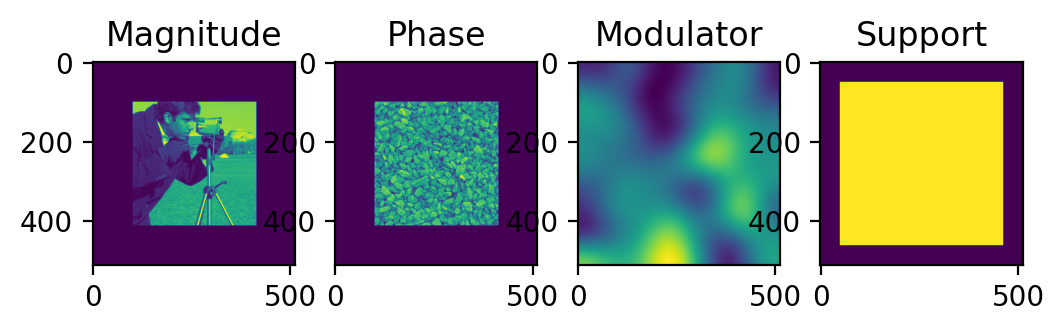

In [29]:
sample_modulator_distance = 1e-2 # meters
beta = 0.5
wavelength = 0.123984193e-9 # meters
niterations = 150

path1 = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/simulation_data/gravel512.npy'
path2 = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/simulation_data/camera512.npy'

phase = np.array( np.load(path1)) 
magnitude = np.array( np.load(path2))

modulator = np.random.rand(*magnitude.shape)
modulator = np.exp(1j*scipy.ndimage.gaussian_filter(modulator, 50))
    
N = 50
mask = np.zeros_like(phase)
mask[2*N:-2*N,2*N:-2*N] = 1
    
phase = phase*mask
magnitude = magnitude*mask

support = np.zeros_like(phase)
support[N:-N,N:-N] = 1

phase = np.pi*phase/np.max(phase)
magnitude = magnitude/np.max(magnitude)
model_object = np.abs(magnitude)*np.exp(1j*phase)

wave_at_detector = np.fft.fftshift(np.fft.fft2(mode_object))
measurement = np.abs(wave_at_detector)**2

initial_guess = np.random.rand(*magnitude.shape)



fig, ax = plt.subplots(1,4,dpi=200)
ax[0].imshow(magnitude), ax[0].set_title('Magnitude')
ax[1].imshow(phase), ax[1].set_title('Phase')
ax[2].imshow(np.angle(modulator)), ax[2].set_title('Modulator')
ax[3].imshow(support), ax[3].set_title('Support')

In [ ]:
def CMI( initial, measure, support, niterations, beta, dev, distance):

    shrinkWrapSubIter = niterations[1]
    gniteration       = niterations[0]

    mempool = cupy.get_default_memory_pool()
    pinned_mempool = cupy.get_default_pinned_memory_pool()

    cupy.cuda.Device(dev).use()

    with cupy.cuda.Device(dev):

        dsupport = cupy.array(support)
        smeasure = cupy.array( measure )
        x        = cupy.array( initial )
        csupport = cupy.array( 1-support )
        xerror   = cupy.array( initial )

        idx = 0

        while ( idx < gniteration ):
            
            x = projection_S( y, dsupport ) + projection_S( x - beta * y,  1-dsupport ) 
            x = propagate_beam(x, distance) # use angular spectrum?
            x = x*modulator
            # y = projection_M_gpu( x, smeasure ) # different in the paper
            
            # propagate to detector
            # magnitude constraint / downsampling
            # backpropagate
            # wavefield update at upstream of modulator
            # backpropagate to support plane
                
            idx += 1

    output = x.get()

    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()

    return output

device = 0
result = CMI( initial, measure, support, niterations, beta, device, sample_modulator_distance)